In [1]:
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import gluon
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

In [ ]:
plt.scatter(X[:, 1].asnumpy(), y.asnumpy(), label="test")
plt.scatter(X[:, 1].asnumpy(), y.asnumpy(), label="test2")
plt.legend()

In [ ]:
num_inputs = 2
num_examples = 2000

true_w = [4, -3.4]
true_b = 4.2

def f(X, w, b):
    y = nd.zeros(X.shape[0]) + b
    for i in range(X.shape[1]):
        y += true_w[i] * X[:, i]
    return y
    
X = nd.random_normal(shape=(num_examples, num_inputs))
y = f(X, true_w, true_b)

def data_iter(batch_size):
    idx = np.arange(num_examples)
    random.shuffle(idx)
    
    for i in np.arange(0, num_examples, batch_size):
        index = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield nd.take(X, index), nd.take(y, index)

w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))

params = [w, b]
for param in params:
    param.attach_grad()
    
def net(X):
    return nd.dot(X, w) + b

def loss(yhat, y):
    # return nd.power(yhat-y, 2)
    return (yhat - y.reshape(yhat.shape))**2

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

def plot_res(losses, data, output, label):
    f, (fig1, fig2) = plt.subplots(1, 2)
    fig1.set_title("Loss during training")
    fig1.plot(np.arange(len(losses)), losses)
    
    fig2.set_title("Estimated vs real function")
    fig2.plot(data.asnumpy(), output.asnumpy(), "or", label="Estimated")
    fig2.plot(data.asnumpy(), label.asnumpy(), "*g", label="Real")
    fig2.legend()
    plt.show()
    
epoches = 5
learning_rate = 0.001
moving_ratio = 0.01
moving_loss = 0
losses = []
niter = 0

for e in range(epoches):
    total_loss = 0
    
    for data, label in data_iter(10):
        with ag.record():
            output = net(data)
            # print(output.shape, label.shape)
            res = loss(output, label)
        res.backward()
        SGD(params, learning_rate)
        total_loss += res.sum().asscalar()
        niter += 1
        
        cur_loss = res.mean().asscalar()
        moving_loss = (1-moving_ratio) * moving_loss + moving_ratio * cur_loss
        est_loss = moving_loss / (1 - (1-moving_ratio)**niter)
        
        
        if niter % 200 == 0:
            losses.append(est_loss)
            print("Epoch {}, batch {}, Moving avg of loss {}, Average loss {}".format(
                e, niter, moving_loss, total_loss/num_examples))
            plot_res(losses, data[:, 1], output, label)

print(w.asnumpy(), true_w)
print(b.asnumpy(), true_b)

In [ ]:
num_inputs = 2
num_examples = 2000

true_w = [4, -3.4]
true_b = 4.2

def f(X, w, b):
    y = nd.zeros(X.shape[0]) + b
    for i in range(X.shape[1]):
        y += true_w[i] * X[:, i]
    return y
    
X = nd.random_normal(shape=(num_examples, num_inputs))
y = f(X, true_w, true_b)

batch_size = 10
dataset = gluon.data.ArrayDataset(X, y)
data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))

square_loss = gluon.loss.L2Loss()

net.initialize()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

epochs = 5
for e in range(epoches):
    total_loss = 0
    for data, label in data_iter:
        with ag.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        total_loss += loss.sum().asscalar()
    print("Epoch {}, average loss {}".format(e, total_loss/num_examples))

print(net[0].weight.data(), w)
print(net[0].bias.data(), b)

In [ ]:
gluon.data.ArrayDataset?

## 多类逻辑回归

In [2]:
def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

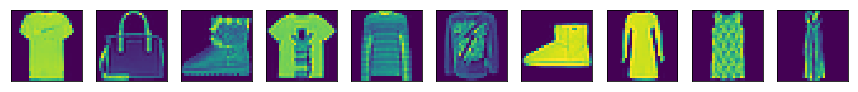

['t-shirt', 'bag', 'ankle boot', 't-shirt', 'pullover', 'pullover', 'ankle boot', 'dress,', 'dress,', 'dress,']


In [7]:
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for fig, data in zip(figs, images):
        fig.imshow(data.reshape((28, 28)).asnumpy())
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    plt.show()

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[10:20]
show_images(data)
print(get_text_labels(label))

In [5]:
batch_size = 256

train_data = gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

num_inputs = 28*28
num_outputs = 10

# mx.random.seed()
W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=(num_outputs))
params = [W, b]

for param in params:
    param.attach_grad()
    
def softmax(X):
    exp = nd.exp(X)
    partition = nd.sum(exp, axis=1, keepdims=True)
    return exp / partition

def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

def cross_entropy(yhat, y):
    return -nd.pick(nd.log(yhat), y)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1) == label).asscalar()

def evaluate_accruacy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

learning_ratio = 0.1
epochs = 5
for e in range(epochs):
    total_loss = 0
    ac = 0
    for data, label in train_data:
        with ag.record():
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward()
        SGD(params, learning_ratio/batch_size)
        
        total_loss += loss.mean().asscalar()
        ac += accuracy(output, label)
    
    ac_t = evaluate_accruacy(test_data, net)
    print("Epoch {:d}. Loss: {:f}, Train acc {:f}, Test acc {:f}".format(
        e, total_loss/len(train_data), ac/len(train_data), ac_t))

Epoch 0. Loss: 3.944842, Train acc 0.439223, Test acc 0.589378
Epoch 1. Loss: 1.957381, Train acc 0.628208, Test acc 0.657048
Epoch 2. Loss: 1.617946, Train acc 0.674474, Test acc 0.687760
Epoch 3. Loss: 1.432703, Train acc 0.699457, Test acc 0.709857
Epoch 4. Loss: 1.310917, Train acc 0.715376, Test acc 0.724695


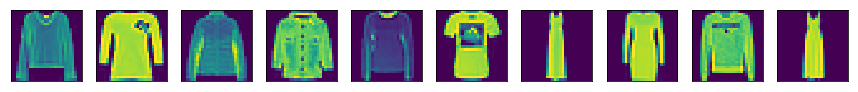

['pullover', 't-shirt', 'coat', 'shirt', 'pullover', 't-shirt', 'dress,', 'dress,', 'pullover', 'dress,']
['shirt', 't-shirt', 'coat', 'pullover', 'pullover', 't-shirt', 'dress,', 'dress,', 'pullover', 'dress,']


In [60]:
sidx = 40

data, label = mnist_test[sidx:min(sidx+10, len(mnist_test))]
label_p = net(data).argmax(axis=1).asnumpy()
show_images(data)
print(get_text_labels(label))
print(get_text_labels(label_p))

### Gluon method

In [9]:
net = gluon.nn.Sequential()

batch_size = 256
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(10))

net.initialize()

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

epochs = 5

for e in range(epochs):
    total_loss = 0
    ac = 0
    for data, label in train_data:
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        total_loss += loss.mean().asscalar()
        ac += accuracy(output, label)
    
    ac_t = evaluate_accruacy(test_data, net)
    print("Epoch {:d}. Loss: {:f}, Train acc {:f}, Test acc {:f}".format(
        e, total_loss/len(train_data), ac/len(train_data), ac_t))   

Epoch 0. Loss: 0.791820, Train acc 0.743855, Test acc 0.805253
Epoch 1. Loss: 0.576155, Train acc 0.809458, Test acc 0.822872
Epoch 2. Loss: 0.530755, Train acc 0.823221, Test acc 0.829422
Epoch 3. Loss: 0.506343, Train acc 0.828485, Test acc 0.832995
Epoch 4. Loss: 0.490279, Train acc 0.833987, Test acc 0.833522


## 多层感知机

In [43]:
num_inputs = 28 * 28
num_ouput = 10
num_hidden = 256
weight_scale = 0.01

W1 = nd.random_normal(shape=(num_inputs, num_hidden), scale=weight_scale)
b1 = nd.zeros(num_hidden)
W2 = nd.random_normal(shape=(num_hidden, num_ouput), scale=weight_scale)
b2 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

def relu(X):
    return nd.maximum(X, 0)

def net(X):
    X = X.reshape((-1, num_inputs))
    h1 = relu(nd.dot(X, W1) + b1)
    output = nd.dot(h1, W2) + b2
    
    return output

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

epochs = 5
batch_size = 256

for e in range(epochs):
    total_loss = 0
    ac = 0
    for data, label in train_data:
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        SGD(params, learning_ratio/batch_size)
        
        total_loss += loss.mean().asscalar()
        ac += accuracy(output, label)
    
    ac_t = evaluate_accruacy(test_data, net)
    print("Epoch {:d}. Loss: {:f}, Train acc {:f}, Test acc {:f}".format(
        e, total_loss/len(train_data), ac/len(train_data), ac_t))   

Epoch 0. Loss: 1.057114, Train acc 0.638597, Test acc 0.765703
Epoch 1. Loss: 0.603081, Train acc 0.787378, Test acc 0.819127
Epoch 2. Loss: 0.526642, Train acc 0.814993, Test acc 0.830779
Epoch 3. Loss: 0.486906, Train acc 0.828674, Test acc 0.838492
Epoch 4. Loss: 0.458965, Train acc 0.838636, Test acc 0.845434


In [53]:
num_inputs = 28 * 28
num_ouput = 10
num_hidden = 256
weight_scale = 0.01

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(256, activation='relu'))
    net.add(gluon.nn.Dense(10))

net.initialize()

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.trainer.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
epochs = 5
batch_size = 256

for e in range(epochs):
    total_loss = 0
    ac = 0
    for data, label in train_data:
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        total_loss += loss.mean().asscalar()
        ac += accuracy(output, label)
    
    ac_t = evaluate_accruacy(test_data, net)
    print("Epoch {:d}. Loss: {:f}, Train acc {:f}, Test acc {:f}".format(
        e, total_loss/len(train_data), ac/len(train_data), ac_t))

Epoch 0. Loss: 0.716510, Train acc 0.737284, Test acc 0.837395
Epoch 1. Loss: 0.468513, Train acc 0.825327, Test acc 0.850903
Epoch 2. Loss: 0.406054, Train acc 0.850305, Test acc 0.856643
Epoch 3. Loss: 0.378096, Train acc 0.860594, Test acc 0.874269
Epoch 4. Loss: 0.356758, Train acc 0.868816, Test acc 0.882862


In [57]:
print(net)

Sequential(
  (0): Flatten
  (1): Dense(784 -> 256, Activation(relu))
  (2): Dense(256 -> 10, linear)
)


In [58]:
print(dir(net))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_alias', '_check_container_with_block', '_children', '_empty_prefix', '_name', '_params', '_prefix', '_scope', 'add', 'cast', 'collect_params', 'forward', 'hybridize', 'initialize', 'load_params', 'name', 'name_scope', 'params', 'prefix', 'register_child', 'save_params']


In [59]:
?nd.Activation

Signature: nd.Activation(data=None, act_type=_Null, out=None, name=None, **kwargs)
Docstring:
Applies an activation function element-wise to the input.

The following activation functions are supported:

- `relu`: Rectified Linear Unit, :math:`y = max(x, 0)`
- `sigmoid`: :math:`y = \frac{1}{1 + exp(-x)}`
- `tanh`: Hyperbolic tangent, :math:`y = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}`
- `softrelu`: Soft ReLU, or SoftPlus, :math:`y = log(1 + exp(x))`
- `softsign`: :math:`y = \frac{x}{1 + abs(x)}`



Defined in src/operator/nn/activation.cc:L154

Parameters
----------
data : NDArray
    The input array.
act_type : {'relu', 'sigmoid', 'softrelu', 'softsign', 'tanh'}, required
    Activation function to be applied.

out : NDArray, optional
    The output NDArray to hold the result.

Returns
-------
out : NDArray or list of NDArrays
    The output of this function.
File:      Dynamically generated function. No source code available.
Type:      function
